In [35]:
import jax
import pennylane as qml
from pennylane import numpy as np
from pennylane import grad
from pennylane.fourier import circuit_spectrum
import matplotlib

In [36]:
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum Layer: First LQ Embed Layer
def lq_embed_1(theta, theta_par):
    for h in range(n_qubits):
        qml.Hadamard(wires=h)
    for i in range(n_qubits):
        qml.RX(theta[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CZ(wires=[i, i+1])
    for i in range(n_qubits):
        qml.RY(theta_par[i], wires=i)

# Quantum Layer: Subsequent Layers
def lq_embed_m(theta, theta_par):
    for i in range(n_qubits):
        qml.RX(theta[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CZ(wires=[i, i+1])
    for i in range(n_qubits):
        qml.RY(theta_par[i], wires=i)

# Full Layerwise Ansatz
@qml.qnode(dev, interface="autograd")
def critic_qnode(inputs, weights):
    lq_embed_1(inputs, weights[0])
    for m in range(1, len(weights)):
        lq_embed_m(inputs, weights[m])
    return qml.expval(qml.PauliZ(0))

In [17]:
@qml.qnode(dev)
def actor_qnode(state_input, theta, theta_par):
    # Apply Hadamard
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    
    # RX with state-dependent angle
    for i in range(n_qubits):
        qml.RX(state_input[i], wires=i)
    
    # Entanglement (CZ between neighbours)
    for i in range(n_qubits - 1):
        qml.CZ(wires=[i, i+1])
    
    # RY with trainable parameter
    for i in range(n_qubits):
        qml.RY(theta_par[i], wires=i)
    
    # Measurement
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [18]:
@qml.qnode(dev)
def critic_qnode(critic_input, theta, theta_par):
    # Build same ansatz as above, with critic_input
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.RX(critic_input[i], wires=i)

    for i in range(n_qubits - 1):
        qml.CZ(wires=[i, i+1])

    for i in range(n_qubits):
        qml.RY(theta_par[i], wires=i)

    # Q-value output (e.g., Z₀ expectation)
    return qml.expval(qml.PauliZ(0))

In [ ]:
m_layers = 3
E_rem = 500e03
num_gus = 4
u = []
uav_pos = [0, 0, 0]
k_shots = 1024

inp_vec = []

for i in range(len(uav_pos)):
    inp_vec.append(uav_pos[i])
inp_vec.append(E_rem)
for j in range(2*num_gus):
    u.append(j)
    inp_vec.append(u[j])

n_qubits = len(inp_vec)
print(n_qubits)
theta_par_inp_vec = np.arange(-np.pi, np.pi, (2*np.pi / (n_qubits - 1)))

theta_arr = x_angle_transformation(n_qubits, inp_vec)
theta_par_arr = x_angle_transformation(n_qubits, theta_par_inp_vec)


In [31]:
# TODO: PROPERLY PORT THE QISKIT VERSION TO PENNYLANE
# TODO: IMPORT THE UAV LQDRL GYM ENVIRONMENT TO GET & UPDATE THESE VALUES AFTER EVERY LAYER
m_layers = 3
E_rem = 500e03
num_gus = 4
u = []
uav_pos = [0, 0, 0]
uav_v_max = 30
zeta_v = 1
uav_v = zeta_v * uav_v_max
noma_g = [1, 2, 3]
pwr_alloc = 1
action_vec = []

action_vec.append(uav_v)
for k in range(len(noma_g)):
    action_vec.append(noma_g[k])
action_vec.append(pwr_alloc)

actor_inp_vec = []
crit_inp_vec = []

for i in range(len(uav_pos)):
    actor_inp_vec.append(uav_pos[i])
actor_inp_vec.append(E_rem)
for j in range(2*num_gus):
    u.append(j)
    actor_inp_vec.append(u[j])

full_input = np.concatenate([actor_inp_vec, action_vec])

n_qubits = len(actor_inp_vec)
n_crit_qubits = len(full_input)

theta = np.zeros(n_qubits, requires_grad=False)
theta_par = np.random.randn(n_qubits, requires_grad=True)

crit_theta = np.zeros(n_crit_qubits, requires_grad=False)
crit_theta_par = np.random.randn(n_crit_qubits, requires_grad=True)

# Forward pass
q_vals = actor_qnode(actor_inp_vec, theta, theta_par)
q_val = critic_qnode(full_input, theta, theta_par)

[0, 0, 0, 500000.0, 0, 1, 2, 3, 4, 5, 6, 7]


(<Figure size 1700x1300 with 1 Axes>, <Axes: >)

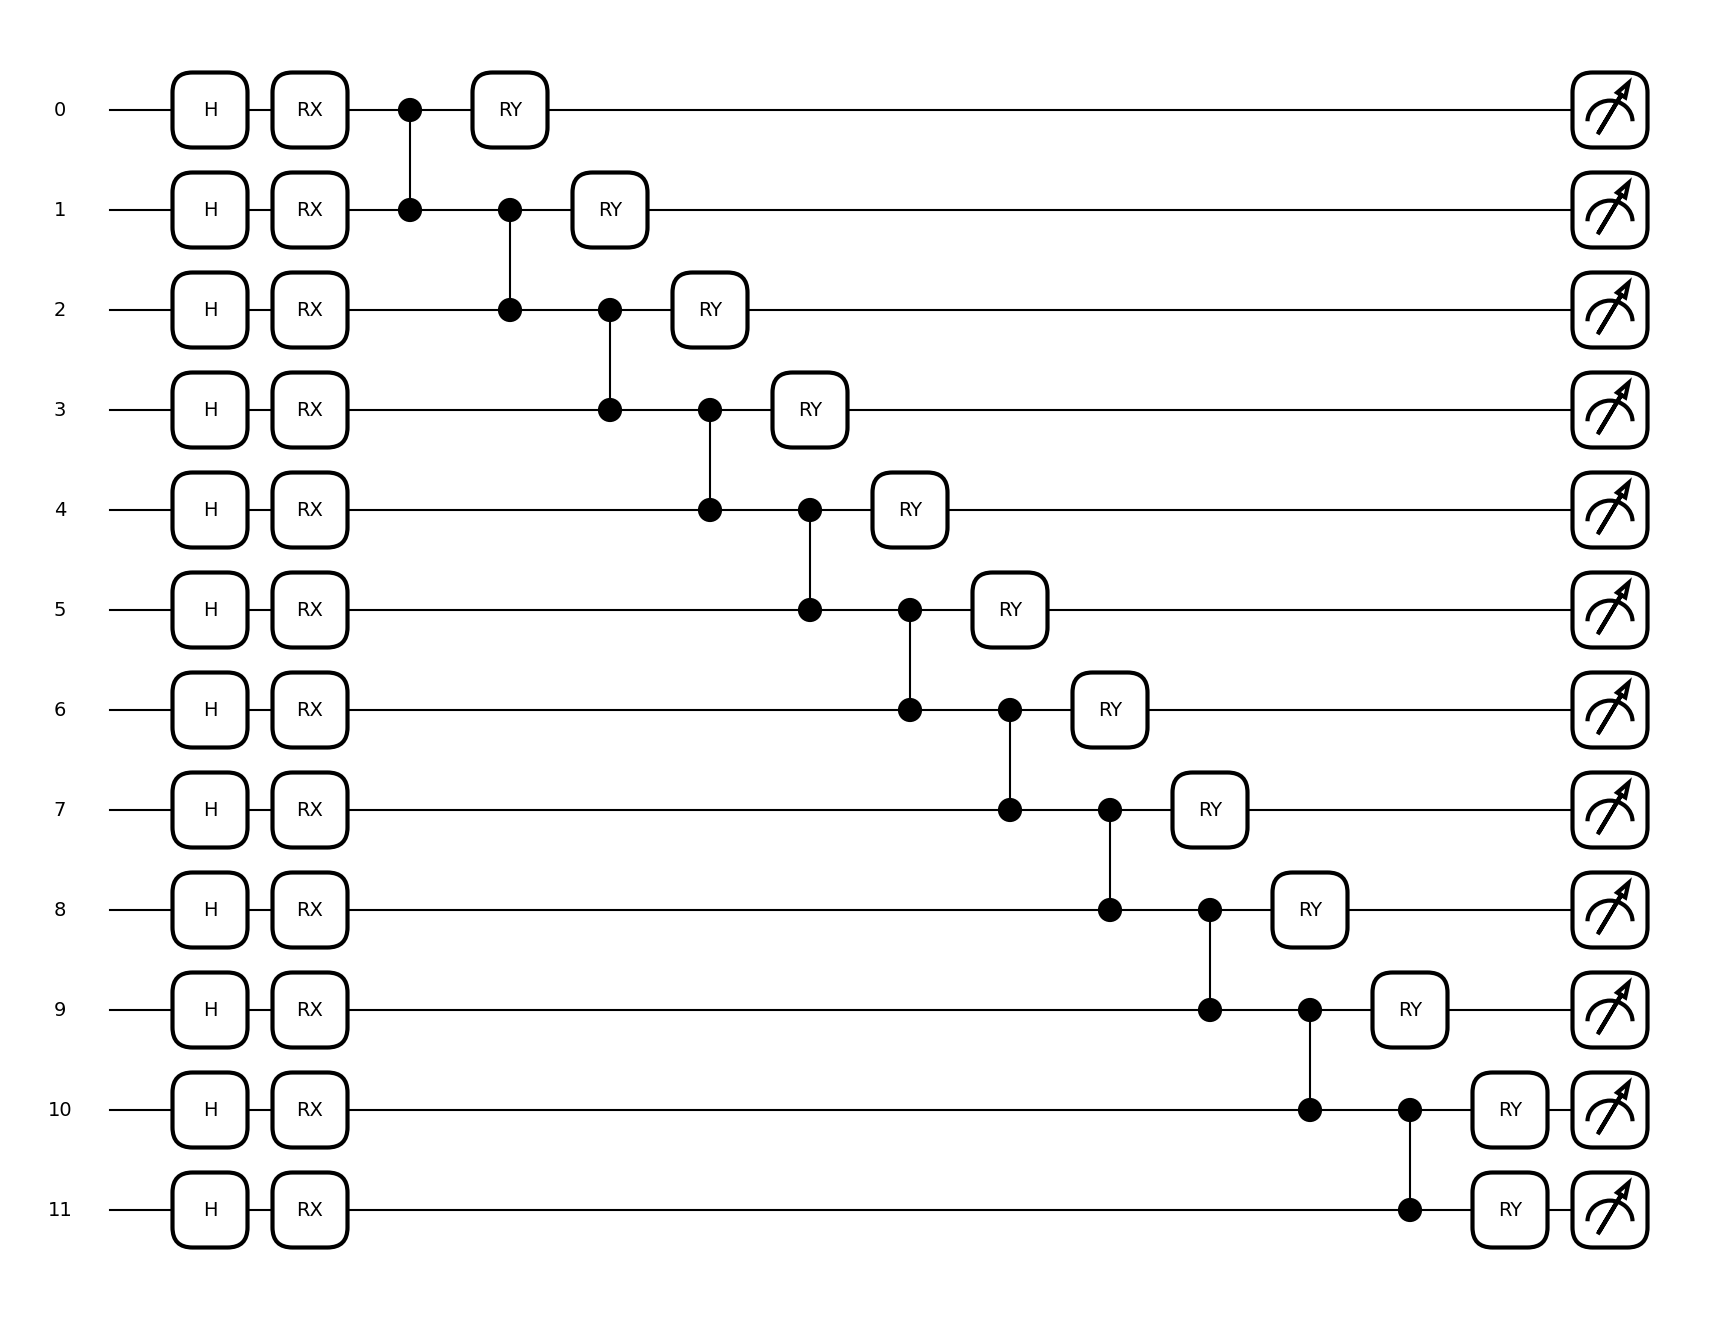

In [46]:
qml.draw_mpl(actor_qnode)(np.ones(n_qubits), np.ones(n_qubits), np.ones(n_qubits))
#dev.actor_qnode.draw(output="mpl")

In [29]:
critic_grad_fn = qml.grad(critic_qnode, argnum=2)
grad_vals = critic_grad_fn(full_input, theta, theta_par)

In [30]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)
for _ in range(10):
    theta_par, loss = opt.step_and_cost(lambda tp: -critic_qnode(full_input, theta, tp), theta_par)
    print("Loss:", loss)

Loss: -5.551115123125783e-17
Loss: -0.0
Loss: -5.551115123125783e-17
Loss: 5.551115123125783e-17
Loss: -0.0
Loss: -5.551115123125783e-17
Loss: -0.0
Loss: 5.551115123125783e-17
Loss: -0.0
Loss: -0.0


In [ ]:
# TODO: Implement updating the theta parameter for the RY gates 
# TODO: Implement updating the x input data vector for the RX gates based on the values stored in the Memory Experience Relay
#num_eps = 10
#for i in range(num_eps):
    